# Set-up

In [68]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.express as px
import seaborn as sns
import numpy as np
import random

sns.set_theme()
colors = sns.color_palette("deep")

from math import floor, ceil, sqrt
from NMF_iter import functional_norm, normalize_curves
from scipy.stats import levene

from itertools import permutations

# HOTFIX Parse IMCEI
import locale
locale.setlocale(locale.LC_ALL, 'it_IT')

'it_IT'

In [195]:
def plot_components(H, ax=None, figsize=(10, 6), labels=None, emphasize_comp=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    abscissa = np.linspace(0, 24, H.shape[1])
    for k in range(n_components):
        if labels:
            label = labels[k]
        else:
            label = f'Component {k + 1}'
        if emphasize_comp and emphasize_comp != k + 1:
            alpha = 0.2
        else:
            alpha = 1
        ax.plot(abscissa, H[k, :], linestyle='-', label=label, alpha=alpha, **kwargs)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Normalized Load')
    # ax.set_title(title)
    ax.legend(loc='upper left')
    
    return fig, ax

In [196]:
# region_order = [
#     'North',
#     'Centre.North',
#     'Sardinia',
#     'Centre.South',
#     'South',
#     'Calabria',
#     'Sicily'
# ]

region_order = [
    'Italy'
]

daytype_order = [
    'Monday',
    'Working day',
    'Saturday',
    'Holiday'
]

# Load selected model and input data

In [197]:
n_comp = 4
n_runs = 1000
opt = 'simp'
specific = '_Italy'

method = f'WHopt{opt}_{n_comp}comp_{n_runs}runs{specific}'
data = np.load('data/3_output/nmf_results/' + method + '.npz', allow_pickle=True)

W = data['W']
H = data['H']

In [198]:
# HOTFIX: reordering components for plotting
# reordering = np.array([2, 1, 0])
# W = W[:, reordering]
# H = H[reordering, :]

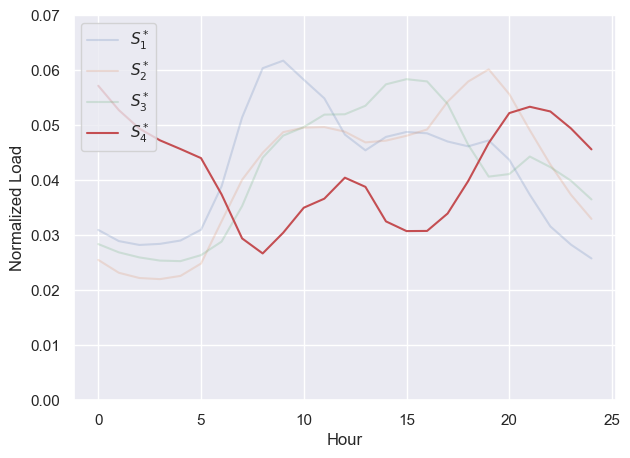

In [254]:
fig, ax = plot_components(H, labels=[f'$S_{i+1}^*$' for i in range(n_comp)], marker=None, linewidth=1.5, figsize=(7, 5), emphasize_comp=4)
left, right = ax.set_ylim((0,0.07))

In [200]:
input_df = pd.read_csv(f'data/2_processed/daily_curves{specific}.csv', index_col=0)
# HOTFIX for single-zone case
zone = 'Italy'
input_df.index = zone + '_' + input_df.index

unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
print(len(df))
df.head(3)

1826


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,region,year,month,daytype
Italy_2018-01-01_Holiday,24743.000,23797.000,22175.999,21042.000,20146.999,20079.000,20942.001,21712.000,21969.999,22967.000,...,31537.000,30804.001,29621.000,27749.000,25388.000,22714.001,Italy,2018,01,Holiday
Italy_2018-01-02_Working day,22714.001,20794.001,19802.002,19573.002,19679.000,20891.000,24197.999,28537.000,32988.000,37794.999,...,42081.001,39555.000,37163.000,33313.000,29811.000,26314.001,Italy,2018,01,Working day
Italy_2018-01-03_Working day,26314.001,24248.999,22927.999,22537.999,22314.001,23529.001,27206.000,32970.999,37419.000,40908.999,...,43818.999,41347.000,38572.999,34229.001,30436.999,27199.000,Italy,2018,01,Working day


# Reconstruct the load per component

In [201]:
X_unnorm = df.drop(unit_info.columns, axis=1)
h = 24 / (X_unnorm.shape[1]-1)
norm_X = X_unnorm.apply(lambda row: functional_norm(row, h), axis=1, raw=True)

curves_comp = {}

for k in range(H.shape[0]):

    W_k = W[:, k]
    H_k = H[k, :]

    curves_k = (norm_X * W_k).values.reshape((len(norm_X), 1)).dot(H_k.reshape((1, H_k.shape[0])))
    # We squeeze the 25th point corresponding to hour 24:00 of day d because it is at the same moment of 00:00 of day d+1 and we want a unique value per time instant
    curves_k = pd.DataFrame(curves_k[:,:-1], columns=range(H_k.shape[0]-1), index=X_unnorm.index)
    curves_k['date'] = curves_k.index.str.split('_').str[1]
    curves_k = pd.concat([curves_k, unit_info], axis=1)

    curves_comp[f'Component {k + 1}'] = curves_k

curves_comp['Component 1']

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,date,region,year,month,daytype
Italy_2018-01-01_Holiday,20.603080,19.250841,18.785323,18.914171,19.318243,20.626931,25.873362,34.217016,40.161986,41.077586,...,31.426802,29.089534,24.857334,21.025430,18.825655,2018-01-01,Italy,2018,01,Holiday
Italy_2018-01-02_Working day,738.254851,689.801065,673.120518,677.737444,692.216257,739.109496,927.100958,1226.072899,1439.094580,1471.902623,...,1126.093229,1042.343652,890.694370,753.388611,674.565704,2018-01-02,Italy,2018,01,Working day
Italy_2018-01-03_Working day,4523.207999,4226.336870,4124.136952,4152.424364,4241.134490,4528.444320,5680.247771,7512.016669,8817.177580,9018.188925,...,6899.451994,6386.327353,5457.188524,4615.930919,4132.991455,2018-01-03,Italy,2018,01,Working day
Italy_2018-01-04_Working day,5247.407051,4903.004658,4784.441778,4817.258214,4920.171486,5253.481745,6589.697447,8714.746093,10228.872917,10462.067665,...,8004.105283,7408.825592,6330.924765,5354.975596,4794.713952,2018-01-04,Italy,2018,01,Working day
Italy_2018-01-05_Working day,5688.025160,5314.703736,5186.185281,5221.757271,5333.312041,5694.609939,7143.025977,9446.512260,11087.778392,11340.554207,...,8676.199844,8030.935272,6862.524482,5804.626099,5197.319996,2018-01-05,Italy,2018,01,Working day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy_2022-12-27_Working day,3717.103031,3473.138886,3389.152559,3412.398721,3485.299343,3721.406160,4667.940588,6173.260204,7245.821443,7411.009486,...,5669.863939,5248.185970,4484.633917,3793.301306,3396.429054,2022-12-27,Italy,2022,12,Working day
Italy_2022-12-28_Working day,4707.124216,4398.182138,4291.826713,4321.264307,4413.581437,4712.573449,5911.209886,7817.459552,9175.689050,9384.873631,...,7179.987648,6645.999066,5679.080923,4803.617303,4301.041245,2022-12-28,Italy,2022,12,Working day
Italy_2022-12-29_Working day,5417.795481,5062.210007,4939.797273,4973.679291,5079.934258,5424.067427,6803.671357,8997.722407,10561.014407,10801.781216,...,8264.006396,7649.397392,6536.496073,5528.856881,4950.402995,2022-12-29,Italy,2022,12,Working day
Italy_2022-12-30_Working day,4560.146221,4260.850730,4157.816209,4186.334627,4275.769193,4565.425303,5726.634816,7573.362629,8889.181976,9091.834855,...,6955.795520,6438.480509,5501.753983,4653.626351,4166.743021,2022-12-30,Italy,2022,12,Working day


In [202]:
info_cols = ['region', 'year', 'month', 'daytype']

comp_df = curves_comp['Component 1'].melt(id_vars=['date']+info_cols, var_name='hour', value_name='Component 1')

for k in range(1, H.shape[0]):
    comp = f'Component {k + 1}'
    comp_df[comp] = curves_comp[comp].melt(id_vars=['date']+info_cols, var_name='hour', value_name='load')['load']

comp_df['date'] = pd.to_datetime(comp_df['date'])
comp_df['datetime'] = comp_df['date'] + pd.to_timedelta(comp_df['hour'], unit='h')
comp_df.set_index('datetime', inplace=True)
comp_df.sort_values(['region', 'date', 'hour'], inplace=True)
comp_df

,date,region,year,month,daytype,hour,Component 1,Component 2,Component 3,Component 4
datetime,,,,,,,,,,
2018-01-01 00:00:00,2018-01-01,Italy,2018,01,Holiday,0,20.603080,5749.486565,3571.913304,15009.616265
2018-01-01 01:00:00,2018-01-01,Italy,2018,01,Holiday,1,19.250841,5222.805641,3382.961759,13848.108890
2018-01-01 02:00:00,2018-01-01,Italy,2018,01,Holiday,2,18.785323,5007.875936,3266.994190,12964.997083
2018-01-01 03:00:00,2018-01-01,Italy,2018,01,Holiday,3,18.914171,4962.574828,3194.156360,12405.343059
2018-01-01 04:00:00,2018-01-01,Italy,2018,01,Holiday,4,19.318243,5093.891870,3181.848069,11989.879622
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,2022-12-31,Italy,2022,12,Saturday,19,5596.956025,14539.515742,4593.535147,8163.059586
2022-12-31 20:00:00,2022-12-31,Italy,2022,12,Saturday,20,5180.700349,13451.751192,4645.968228,9112.645439
2022-12-31 21:00:00,2022-12-31,Italy,2022,12,Saturday,21,4426.966694,11865.691648,5005.993148,9313.130684


# Up-sample

In [203]:
day_df = comp_df.groupby(['region', 'year', 'month', 'date', 'daytype'], as_index=False)[[f'Component {k+1}' for k in range(H.shape[0])]].sum()
day_df

,region,year,month,date,daytype,Component 1,Component 2,Component 3,Component 4
0,Italy,2018,01,2018-01-01,Holiday,680.308854,226150.933465,126343.256652,260749.662255
1,Italy,2018,01,2018-01-02,Working day,24377.001571,523005.641761,172313.697819,60988.005359
2,Italy,2018,01,2018-01-03,Working day,149355.264539,448108.419915,148803.387497,91068.229648
3,Italy,2018,01,2018-01-04,Working day,173268.146936,408661.101403,133178.613103,123244.929634
4,Italy,2018,01,2018-01-05,Working day,187817.253302,393506.886873,153113.818106,111972.360865
...,...,...,...,...,...,...,...,...,...
1821,Italy,2022,12,2022-12-27,Working day,122737.868053,329921.211136,141115.135688,84781.634360
1822,Italy,2022,12,2022-12-28,Working day,155428.134791,321137.577234,120657.475393,97293.050495
1823,Italy,2022,12,2022-12-29,Working day,178894.332832,280131.235239,98392.209783,121210.577554
1824,Italy,2022,12,2022-12-30,Working day,150574.955928,284543.845034,94653.186254,130691.625730


In [204]:
month_df = comp_df.groupby(['region', 'year', 'month'], as_index=False)[[f'Component {k+1}' for k in range(H.shape[0])]].sum()
month_df

,region,year,month,Component 1,Component 2,Component 3,Component 4
0,Italy,2018,01,7.408463e+06,1.170923e+07,4.053543e+06,4.310318e+06
1,Italy,2018,02,7.701980e+06,9.691691e+06,4.378291e+06,4.314841e+06
2,Italy,2018,03,8.945811e+06,8.758640e+06,4.570416e+06,5.571579e+06
3,Italy,2018,04,7.513491e+06,5.069703e+06,5.640780e+06,6.294897e+06
4,Italy,2018,05,6.955143e+06,4.145595e+06,9.066141e+06,6.095614e+06
5,Italy,2018,06,6.544347e+06,3.161931e+06,1.088072e+07,6.412383e+06
6,Italy,2018,07,5.293137e+06,3.925011e+06,1.360316e+07,7.356600e+06
7,Italy,2018,08,3.556388e+06,4.158735e+06,1.071669e+07,7.908907e+06
8,Italy,2018,09,7.293790e+06,5.282063e+06,7.510832e+06,6.769223e+06
9,Italy,2018,10,8.739605e+06,7.752723e+06,4.421283e+06,5.670370e+06


In [205]:
year_df = comp_df.groupby(['region', 'year'], as_index=False)[[f'Component {k+1}' for k in range(H.shape[0])]].sum()
year_df

,region,year,Component 1,Component 2,Component 3,Component 4
0,Italy,2018,8.301904e+07,8.536012e+07,8.359733e+07,6.968284e+07
1,Italy,2019,8.201262e+07,8.753415e+07,8.129508e+07,6.890817e+07
2,Italy,2020,7.252869e+07,8.557316e+07,7.336076e+07,7.006894e+07
3,Italy,2021,8.886252e+07,7.212783e+07,8.691252e+07,7.037065e+07
4,Italy,2022,9.026352e+07,6.442986e+07,8.773939e+07,7.301351e+07


# Analysis

In [206]:
component = 'Component 4'
region = 'Italy'
df_plot = day_df[day_df.region == region]

fig = px.line(
    df_plot,
    x = 'date',
    y = component,
    title = f'Total Load Evolution of {component} for region {region} [MW]',
    height = 700,
    hover_data={'date': '|%B %d, %Y', component: True, 'daytype': True}
)

fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Load')
fig.show()

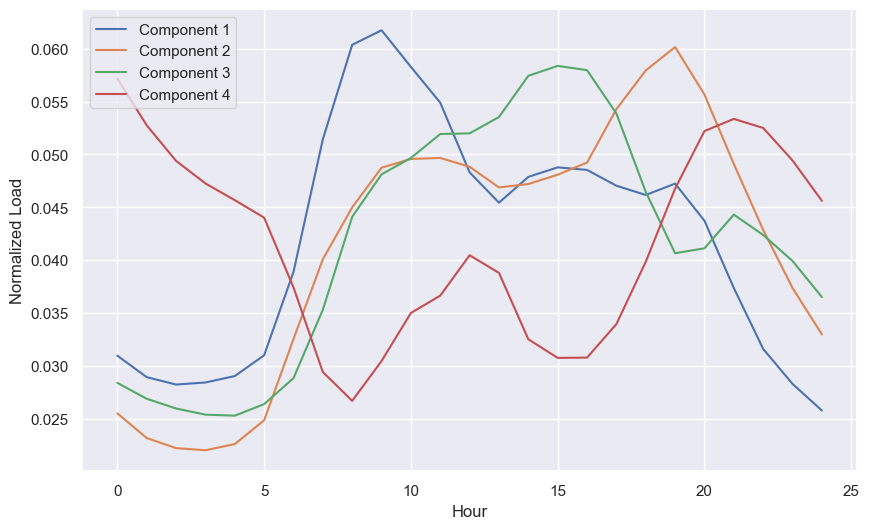

In [207]:
fig, ax = plot_components(H)

In [208]:
day_df.groupby(['daytype'])[[f'Component {k+1}' for k in range(H.shape[0])]].mean()

,Component 1,Component 2,Component 3,Component 4
daytype,,,,
Holiday,65382.163097,189825.771025,133528.485686,290753.165172
Monday,150074.729003,355378.212777,306940.810200,81116.368341
Saturday,275476.440467,115683.160780,94435.212274,291755.691559
Working day,284617.594695,215070.439476,266711.675004,166279.087533


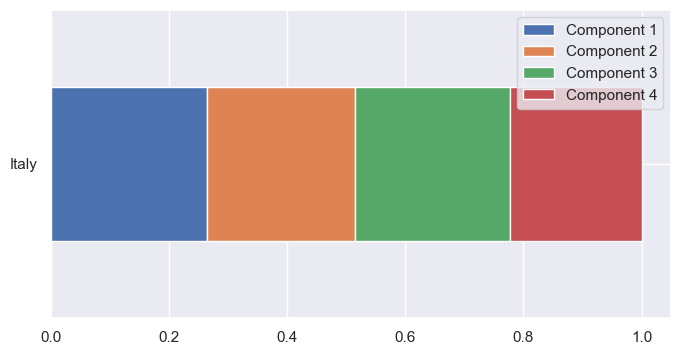

In [209]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
df_plot = year_df.groupby('region').sum().drop('year', axis=1)
df_plot = df_plot.div(df_plot.sum(axis=1), axis=0)
df_plot.plot.barh(stacked=True, ax=ax)
ax = ax.set_ylabel("")

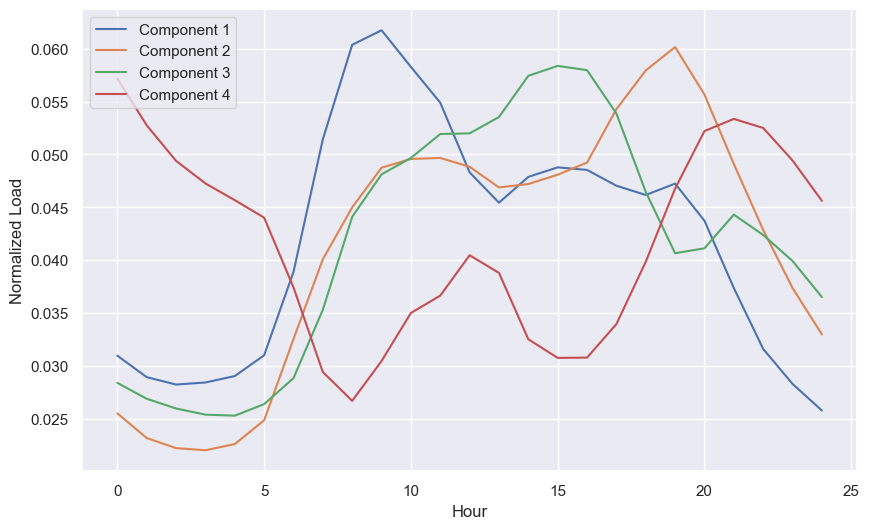

In [210]:
fig, ax = plot_components(H)

In [211]:
year_df.groupby('region').sum().drop('year', axis=1)

,Component 1,Component 2,Component 3,Component 4
region,,,,
Italy,4.166864e+08,3.950251e+08,4.129051e+08,3.520441e+08


In [212]:
month_df.groupby(['year', 'month'], as_index=False).sum().drop('region', axis=1)

,year,month,Component 1,Component 2,Component 3,Component 4
0,2018,01,7.408463e+06,1.170923e+07,4.053543e+06,4.310318e+06
1,2018,02,7.701980e+06,9.691691e+06,4.378291e+06,4.314841e+06
2,2018,03,8.945811e+06,8.758640e+06,4.570416e+06,5.571579e+06
3,2018,04,7.513491e+06,5.069703e+06,5.640780e+06,6.294897e+06
4,2018,05,6.955143e+06,4.145595e+06,9.066141e+06,6.095614e+06
5,2018,06,6.544347e+06,3.161931e+06,1.088072e+07,6.412383e+06
6,2018,07,5.293137e+06,3.925011e+06,1.360316e+07,7.356600e+06
7,2018,08,3.556388e+06,4.158735e+06,1.071669e+07,7.908907e+06
8,2018,09,7.293790e+06,5.282063e+06,7.510832e+06,6.769223e+06
9,2018,10,8.739605e+06,7.752723e+06,4.421283e+06,5.670370e+06


Add plot of data from the IMSER

In [213]:
imser = pd.read_excel('data/1_input/indicators/IMSER.xlsx')
imser.head()

,Mese,IMSER (GWh)
0,2019-01-01,6967.533119
1,2019-02-01,6035.026729
2,2019-03-01,6228.592501
3,2019-04-01,5791.385319
4,2019-05-01,6084.349844


In [214]:
imcei = pd.read_excel('data/1_input/indicators/IMCEI_mensile.xlsx')
imcei['Mese'] = pd.to_datetime(imcei['Anno'].astype(str) + '-' + imcei['Mese'], format='%Y-%b')
imcei.head()

,Anno,Mese,IMCEI Mensile
0,2018,2018-01-01,101.876892
1,2018,2018-02-01,104.070890
2,2018,2018-03-01,112.023582
3,2018,2018-04-01,102.915390
4,2018,2018-05-01,113.072924


In [215]:
domestic = pd.read_excel('data/1_input/indicators/Domestico 2020 e 2021.xlsx', skiprows=12, usecols=range(3))
domestic.head()

,Mese,Domestico kWh,Domestico GWh
0,2020-01-01,4.741474e+09,4741.474351
1,2020-02-01,4.120931e+09,4120.931091
2,2020-03-01,4.571397e+09,4571.397146
3,2020-04-01,4.056376e+09,4056.375574
4,2020-05-01,3.817226e+09,3817.225967


Correlation between the two series: 0.815


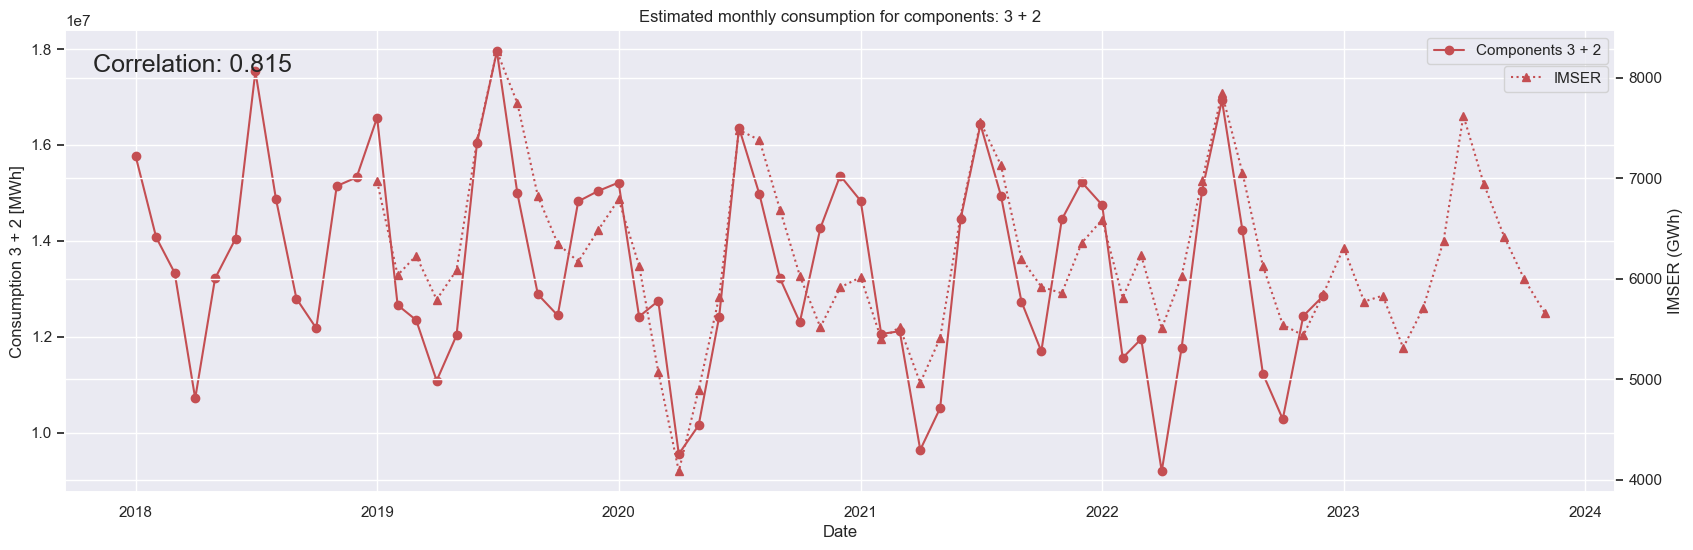

In [229]:
# Convert year and month to datetime
df_plot = month_df.groupby(['year', 'month'], as_index=False).sum().drop('region', axis=1)
df_plot['date'] = pd.to_datetime(df_plot['year'].astype(str) + '-' + df_plot['month'], format='%Y-%m')

# Drop year and month columns
df_plot.drop(columns=['year', 'month'], inplace=True)

# Set the 'date' column as the index
df_plot.set_index('date', inplace=True)

# Plotting the first component
plt.figure(figsize=(20, 6))
ax1 = plt.gca()  # get current axes

# Plot the first component on the primary y-axis
comp_to_sum = [3, 2]
est_cons = df_plot[[f'Component {k}' for k in comp_to_sum]].sum(axis=1)
ax1.plot(df_plot.index, est_cons, label='Components {}'.format(' + '.join([str(comp) for comp in comp_to_sum])), marker='o', color=colors[k])
ax1.set_xlabel('Date')
ax1.set_ylabel('Consumption {} [MWh]'.format(' + '.join([str(comp) for comp in comp_to_sum])))
ax1.set_title('Estimated monthly consumption for components: {}'.format(' + '.join([str(comp) for comp in comp_to_sum])))
ax1.legend()
# ax1.set_ylim((0, 1.5e7))

ax2 = ax1.twinx()
ax2.plot(imser.Mese, imser['IMSER (GWh)'], label='IMSER', marker='^', color=colors[k], linestyle='dotted')
ax2.set_ylabel('IMSER (GWh)')
ax2.legend(loc='upper right', bbox_to_anchor=(1,0.94))

corr = est_cons.corr(imser.set_index('Mese')['IMSER (GWh)'])

# Add annotation for correlation coefficient
ax1.annotate('Correlation: {:.3f}'.format(corr), xy=(0.0, 0.85), xycoords='axes fraction',
            xytext=(20, 20), textcoords='offset points',  fontsize=18)

print('Correlation between the two series: {:.3f}'.format(corr))

# Show plot
plt.show()

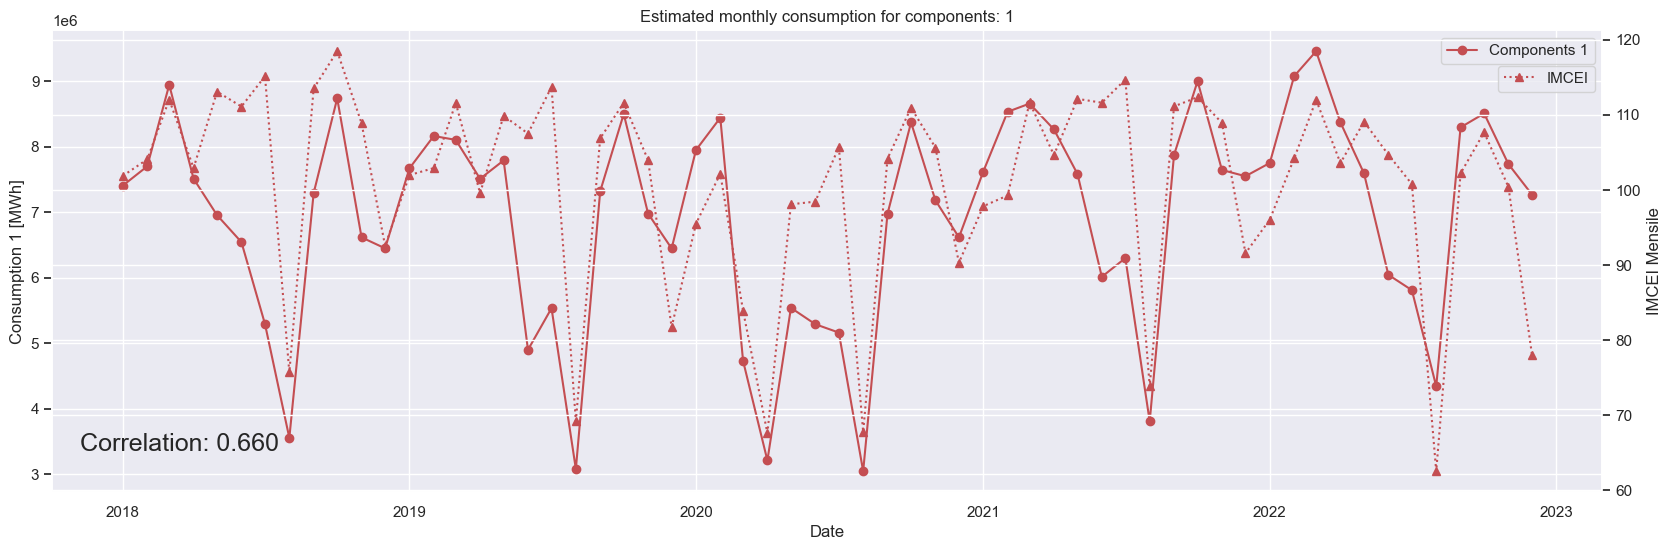

In [256]:
# Plotting the first component
plt.figure(figsize=(20, 6))
ax1 = plt.gca()  # get current axes

# Plot the first component on the primary y-axis
comp_to_sum = [1]
# ax1.plot(df_plot.index, df_plot[col], label=col, marker='o', color=colors[k])
est_cons = df_plot[[f'Component {k}' for k in comp_to_sum]].sum(axis=1)

ax1.plot(df_plot.index, est_cons, label='Components {}'.format(' + '.join([str(comp) for comp in comp_to_sum])), marker='o', color=colors[k])
ax1.set_xlabel('Date')
ax1.set_ylabel('Consumption {} [MWh]'.format(' + '.join([str(comp) for comp in comp_to_sum])))
ax1.set_title('Estimated monthly consumption for components: {}'.format(' + '.join([str(comp) for comp in comp_to_sum])))
ax1.legend()
# ax1.set_ylim((0, 1.5e7))

ax2 = ax1.twinx()
ax2.plot(imcei.Mese, imcei['IMCEI Mensile'], label='IMCEI', marker='^', color=colors[k], linestyle='dotted')
ax2.set_ylabel('IMCEI Mensile')
ax2.legend(loc='upper right', bbox_to_anchor=(1,0.94))

corr = est_cons.corr(imcei.set_index('Mese')['IMCEI Mensile'])

# Add annotation for correlation coefficient
ax1.annotate('Correlation: {:.3f}'.format(corr), xy=(0.0, 0.03), xycoords='axes fraction',
            xytext=(20, 20), textcoords='offset points',  fontsize=18)

# Show plot
plt.show()

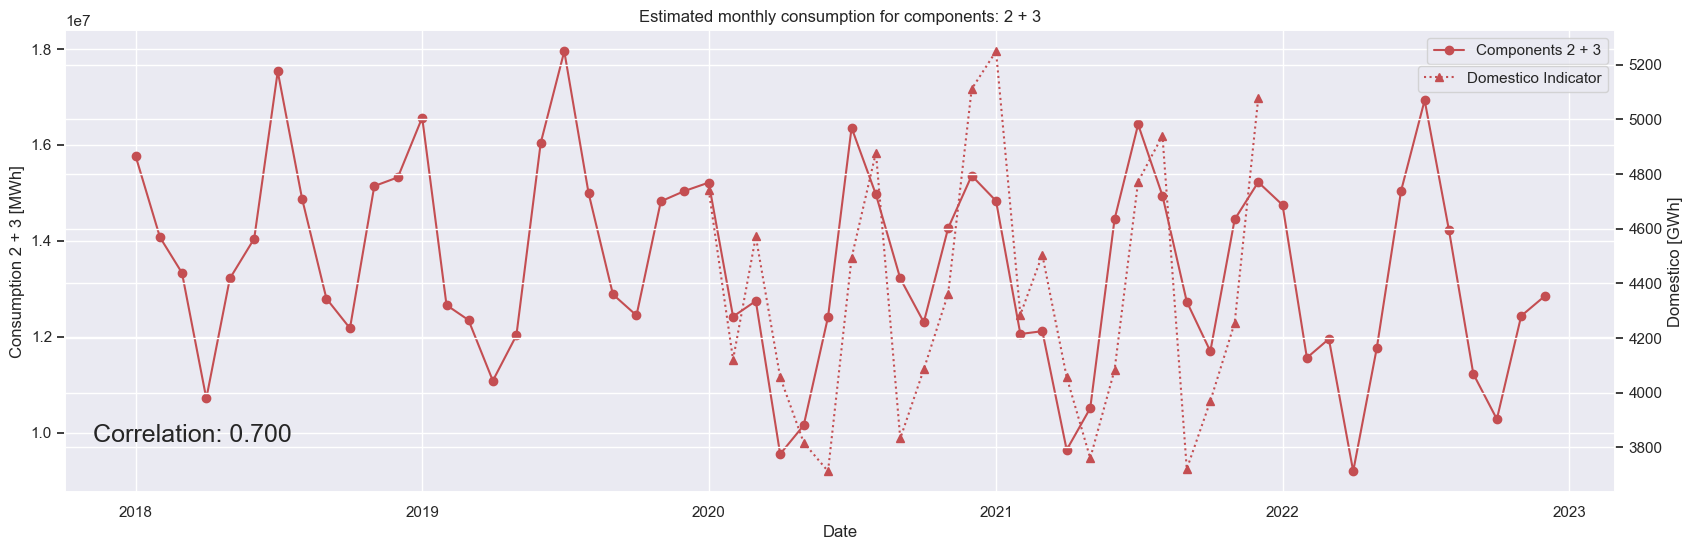

In [250]:
# Plotting the first component
plt.figure(figsize=(20, 6))
ax1 = plt.gca()  # get current axes

# Plot the first component on the primary y-axis
comp_to_sum = [2, 3]
# ax1.plot(df_plot.index, df_plot[col], label=col, marker='o', color=colors[k])
est_cons = df_plot[[f'Component {k}' for k in comp_to_sum]].sum(axis=1)

ax1.plot(df_plot.index, est_cons, label='Components {}'.format(' + '.join([str(comp) for comp in comp_to_sum])), marker='o', color=colors[k])
ax1.set_xlabel('Date')
ax1.set_ylabel('Consumption {} [MWh]'.format(' + '.join([str(comp) for comp in comp_to_sum])))
ax1.set_title('Estimated monthly consumption for components: {}'.format(' + '.join([str(comp) for comp in comp_to_sum])))
ax1.legend()
# ax1.set_ylim((0, 1.5e7))

ax2 = ax1.twinx()
ax2.plot(domestic.Mese, domestic['Domestico GWh'], label='Domestico Indicator', marker='^', color=colors[k], linestyle='dotted')
ax2.set_ylabel('Domestico [GWh]')
ax2.legend(loc='upper right', bbox_to_anchor=(1,0.94))

# corr = df_plot[col].corr(domestic.set_index('Mese')['Domestico GWh'])
corr = est_cons.corr(domestic.set_index('Mese')['Domestico GWh'])

# Add annotation for correlation coefficient
ax1.annotate('Correlation: {:.3f}'.format(corr), xy=(0.0, 0.05), xycoords='axes fraction',
            xytext=(20, 20), textcoords='offset points',  fontsize=18)

# Show plot
plt.show()

In [63]:
df_plot = month_df.groupby(['year', 'month'], as_index=False).sum().drop('region', axis=1)
df_plot.head()

,year,month,Component 1,Component 2,Component 3,Component 4
0,2018,01,7.408463e+06,1.170923e+07,4.053543e+06,4.310318e+06
1,2018,02,7.701980e+06,9.691691e+06,4.378291e+06,4.314841e+06
2,2018,03,8.945811e+06,8.758640e+06,4.570416e+06,5.571579e+06
3,2018,04,7.513491e+06,5.069703e+06,5.640780e+06,6.294897e+06
4,2018,05,6.955143e+06,4.145595e+06,9.066141e+06,6.095614e+06


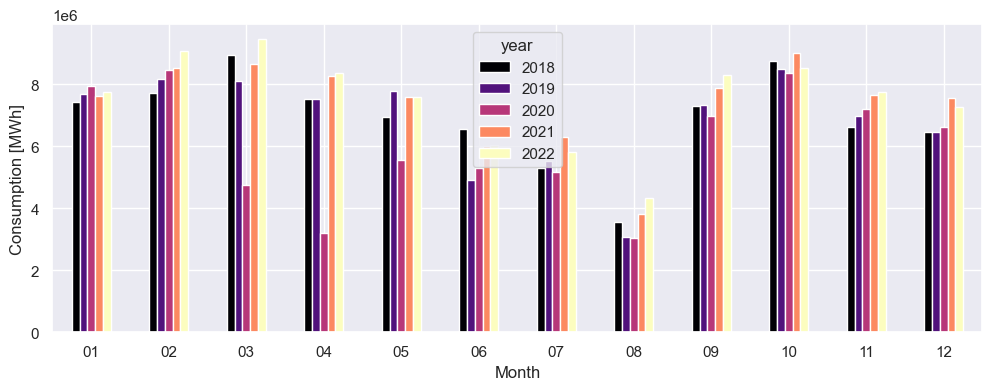

In [64]:
fig, ax = plt.subplots(figsize=(12,4))
df_plot.pivot(columns='year', index='month', values='Component 1').plot.bar(ax=ax, colormap='magma')
ticks = plt.xticks(rotation=0)
ylabel = plt.ylabel('Consumption [MWh]')
xlabel = plt.xlabel('Month')

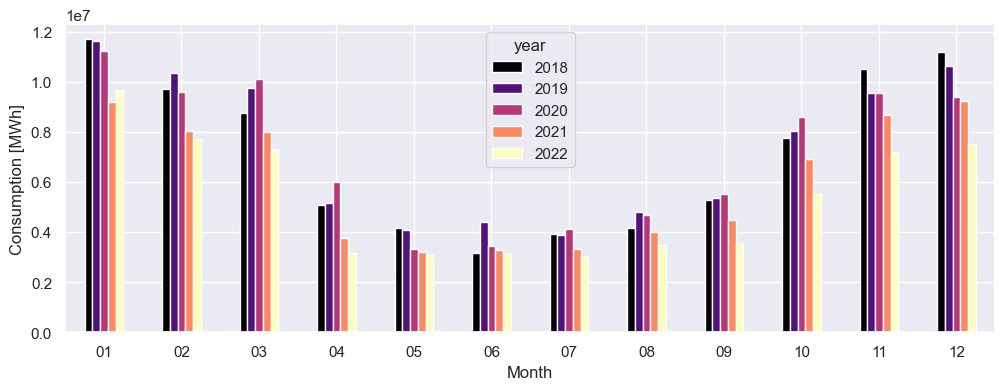

In [65]:
fig, ax = plt.subplots(figsize=(12,4))
df_plot.pivot(columns='year', index='month', values='Component 2').plot.bar(ax=ax, colormap='magma')
ticks = plt.xticks(rotation=0)
ylabel = plt.ylabel('Consumption [MWh]')
xlabel = plt.xlabel('Month')

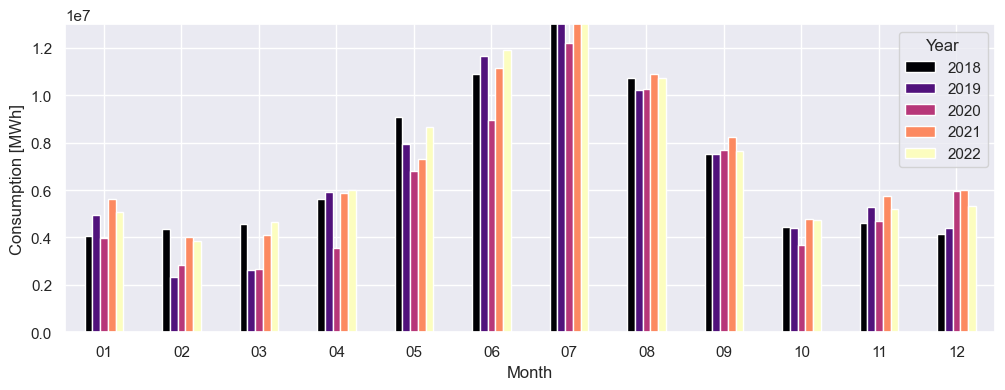

In [66]:
fig, ax = plt.subplots(figsize=(12,4))
df_plot.pivot(columns='year', index='month', values='Component 3').plot.bar(ax=ax, colormap='magma')
ticks = plt.xticks(rotation=0)
ylabel = plt.ylabel('Consumption [MWh]')
xlabel = plt.xlabel('Month')
ylim = plt.ylim((0., 1.3e7))
legend = plt.legend(loc='upper right', title='Year')

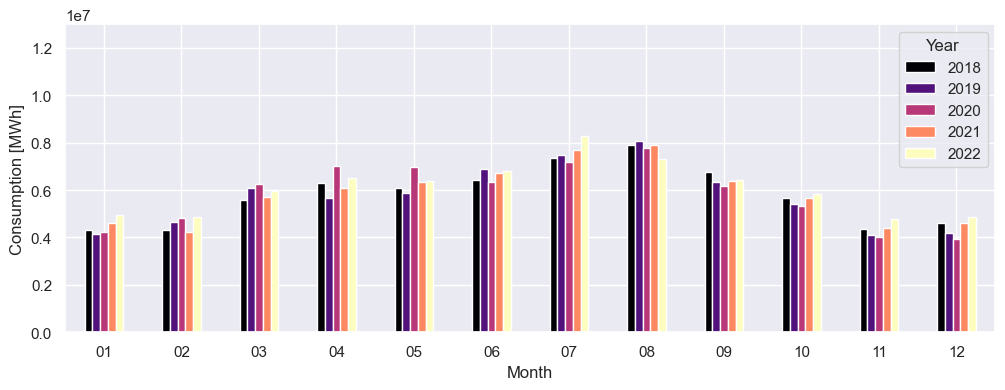

In [67]:
fig, ax = plt.subplots(figsize=(12,4))
df_plot.pivot(columns='year', index='month', values='Component 4').plot.bar(ax=ax, colormap='magma')
ticks = plt.xticks(rotation=0)
ylabel = plt.ylabel('Consumption [MWh]')
xlabel = plt.xlabel('Month')
ylim = plt.ylim((0., 1.3e7))
legend = plt.legend(loc='upper right', title='Year')

<HR>

# TESTS

In [41]:
df.groupby(['region', 'year'], sort=False).size()

region        year
Calabria      2021    365
              2022    365
Centre.North  2018    365
              2019    365
              2020    366
              2021    365
              2022    365
Centre.South  2018    365
              2019    365
              2020    366
              2021    365
              2022    365
North         2018    365
              2019    365
              2020    366
              2021    365
              2022    365
Sardinia      2018    365
              2019    365
              2020    366
              2021    365
              2022    365
Sicily        2018    365
              2019    365
              2020    366
              2021    365
              2022    365
South         2018    365
              2019    365
              2020    366
              2021    365
              2022    365
dtype: int64

In [ ]:
component = 'Component 3'
# region = 'North'

fig = px.bar(
    month_df.groupby(['year', 'month'], as_index=False)[component].sum(),
    x = 'month',
    y = component,
    color='year',
    title = f'Total monthly consumption of {component} for region {region} [MWh]',
    height = 500,
    barmode='group'
)

fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Consumption')
fig.show()

NameError: name 'region' is not defined